## Upload the dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving tweets.csv to tweets.csv


## Read the file and inspect

In [2]:
import pandas as pd
df = pd.read_csv('./tweets.csv')
df.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [3]:
df.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

In [4]:
# Calling all GODs
import random
import torch, torchtext
from torchtext.legacy import data 

# Manual Seed
SEED = 123
torch.manual_seed(SEED)

## Tokenize using *Spacy* package

In [5]:
Tweet = data.Field(sequential = True, 
                   tokenize = 'spacy', 
                   batch_first =True, 
                   include_lengths=True) # batch_first means : [batch, channel, r,g,b] : here batch is first

Label = data.LabelField(tokenize ='spacy', 
                        is_target=True, 
                        batch_first =True, 
                        sequential =False)

In [6]:
fields = [('tweet', Tweet), ('label', Label)]

In [7]:
example = [torchtext.legacy.data.Example.fromlist([df.tweets[i],df.labels[i]], fields) for i in range(df.shape[0])] 

In [8]:
twitterDataset = torchtext.legacy.data.Dataset(example, fields)

## Split into Train and Validation dataset

Could also use stratified sampling here

In [9]:
(train, valid) = twitterDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))

In [10]:
(len(train), len(valid))

(1159, 205)

In [11]:
vars(train.examples[5]) # returning dict attributes

{'label': 0,
 'tweet': ['@Harry_Styles',
  'Barack',
  'obama',
  'should',
  'hide',
  'his',
  'kids',
  'and',
  'hide',
  'his',
  'wife']}

In [12]:
Tweet.build_vocab(train)
Label.build_vocab(train)

In [13]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4652
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1062), (':', 797), ('#', 787), ('.', 748), (',', 601), ('"', 573), ('the', 540), ('RT', 513), ('?', 415), ('to', 401)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Create an Iterator, used to fetch a batch of records at once

In [15]:
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweet),
                                                            sort_within_batch=True, device = device)

In [16]:
next(iter(train_iterator))
#len(train.examples[11].tweet)


[torchtext.legacy.data.batch.Batch of size 32]
	[.tweet]:('[torch.LongTensor of size 32x30]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

In [17]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

## Playground with sample dataset

### To understand step by step encoder- decoder (LSTM, RNN), input/ outputs

In [18]:
for batch in train_iterator:
  tweet, tweet_lengths = batch.tweet
  break

#print('tweet:', tweet, '')
print('tweet length: ', tweet_lengths)

tweet length:  tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])


In [19]:
vocab_size = len(Tweet.vocab)
vocab_size

4652

In [20]:
print(tweet[2,])
print(tweet_lengths[2,])
print('tweet.shape : ', tweet.shape)
print('tweet_length shape : ', tweet_lengths.shape)

tensor([   9,  656,    3,    7,  870,  963, 3190,    5,   64,    2, 2528, 2554,
           3, 3779,   69,  238])
tensor(16)
tweet.shape :  torch.Size([32, 16])
tweet_length shape :  torch.Size([32])


### Sample Encoder step by step

In [21]:
import torch.nn as nn
import torch.nn.functional as F

embedding_dim = 300
hidden_dim = 100

# Encoder Sample
embedding = nn.Embedding(vocab_size, embedding_dim)

encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=1, 
                           batch_first=True
                          )
# Forward Pass
embedded = embedding(tweet)
print('embedded.shape: ', embedded.shape)

packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, tweet_lengths.cpu(), batch_first=True)

# ENCODER Passing through
packed_output, (hidden, cell) = encoder(packed_embedded)

# Unpack
output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
print('output shape: ', output.shape)

print('hidden : ', hidden.shape)
print('cell : ', cell.shape)


embedded.shape:  torch.Size([32, 16, 300])
output shape:  torch.Size([32, 16, 100])
hidden :  torch.Size([1, 32, 100])
cell :  torch.Size([1, 32, 100])


In [22]:
print(cell)
print(hidden)

tensor([[[ 0.5995,  0.3513, -0.0652,  ..., -0.1756, -0.0627, -0.6227],
         [-0.5119, -0.0560,  0.4343,  ..., -0.1676, -0.0839, -0.2324],
         [ 0.0118,  0.0953,  0.0258,  ...,  0.0281, -0.6045,  0.4446],
         ...,
         [ 0.7540,  0.0751, -0.3182,  ..., -0.2279,  0.2224, -0.2980],
         [-0.4197,  0.1607,  0.1608,  ...,  0.2872, -0.2453,  0.4741],
         [ 0.4902,  0.3600, -0.3287,  ...,  0.0116,  0.0177, -0.6820]]],
       grad_fn=<StackBackward>)
tensor([[[ 0.3661,  0.1778, -0.0535,  ..., -0.1221, -0.0317, -0.3342],
         [-0.2726, -0.0117,  0.2815,  ..., -0.0532, -0.0625, -0.0995],
         [ 0.0049,  0.0665,  0.0214,  ...,  0.0106, -0.3701,  0.1403],
         ...,
         [ 0.4124,  0.0413, -0.2577,  ..., -0.1558,  0.1198, -0.1739],
         [-0.1004,  0.1108,  0.0507,  ...,  0.1993, -0.1042,  0.2071],
         [ 0.2052,  0.2689, -0.1969,  ...,  0.0039,  0.0130, -0.1544]]],
       grad_fn=<StackBackward>)


In [23]:
packed_output.data[0,]
print('output_lengths : ', output_lengths.shape)

print(output[0,0,:]) # first Batch, first sentence, first word

output_lengths :  torch.Size([32])
tensor([-0.0414, -0.1430,  0.1530, -0.1467, -0.3452,  0.0542,  0.1843,  0.1219,
        -0.0265,  0.2277,  0.0518, -0.1262, -0.1704,  0.0439, -0.1707, -0.2472,
        -0.0945, -0.0299, -0.0788,  0.1532, -0.0148, -0.1048, -0.0446, -0.0786,
        -0.3029,  0.1788, -0.0614,  0.0672,  0.0799,  0.1016,  0.0386,  0.1359,
         0.0271,  0.0088, -0.0759,  0.0549, -0.2611,  0.0819,  0.2373,  0.2670,
         0.0356,  0.0319,  0.1002,  0.0064,  0.1675,  0.1593,  0.0324, -0.0473,
         0.0653, -0.2006, -0.0619, -0.2141,  0.0822, -0.0832, -0.1290,  0.0444,
         0.3977, -0.1298,  0.1112, -0.1089, -0.1077,  0.2292, -0.0251,  0.2253,
         0.0407,  0.1509, -0.1392,  0.3322,  0.1274,  0.1091, -0.0953, -0.5174,
         0.0875,  0.0338,  0.3810, -0.0725,  0.0193, -0.3379,  0.0532, -0.0948,
         0.1146,  0.1629, -0.2807,  0.0423, -0.2807,  0.0483, -0.1101,  0.1432,
         0.4219,  0.1708, -0.1254, -0.0538,  0.0313,  0.3626,  0.1155,  0.0799,
     

In [24]:
packed_output.data.shape # so we need to unpack

torch.Size([492, 100])

In [25]:
encoder_output = output
output.shape

torch.Size([32, 16, 100])

### Sample Decoder step by step

In [26]:
# Sample Decoder

# Define
decoder = nn.LSTM(100, 
                  75, 
                  num_layers=1, 
                  batch_first=True)

fc= nn.Linear(75, 3)

# Pass
output, (hidden_decoder, cell_decoder) = decoder(encoder_output)
print('decoder output shape', output.shape)
print('decoder hidden shape', hidden_decoder.shape)
print('decoder cell shape', cell_decoder.shape)

dense_outputs = fc(hidden_decoder)
print('decoder cell shape', cell_decoder.shape)

final_output = F.softmax(dense_outputs[0], dim=1)
print('final_output Shape', final_output.shape)

decoder output shape torch.Size([32, 16, 75])
decoder hidden shape torch.Size([1, 32, 75])
decoder cell shape torch.Size([1, 32, 75])
decoder cell shape torch.Size([1, 32, 75])
final_output Shape torch.Size([32, 3])


## Encoder Class

Let's write an encoder class from above understanding

It does 
1. Embeddings
2. Word from a sentence + last hidden vector -> encoder (LSTM )
3. Output 

  a. single vector ( to be used by Decoder )

  b. embeddings of word ( to be used for visualization purpose )

In [27]:
#********************************************************************************
#******************** Final Econder Class ***************************************
#********************************************************************************

class Encoder(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           #dropout=dropout,
                           batch_first=True)


    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        # pass to encoder
        packed_output, (hidden_encoder, cell_encoder) = self.encoder(packed_embedded)

        # unpack sequence
        encoder_output, encoder_output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
    
        # encoder o/p for decoder ; embedded for visualization purpose
        return encoder_output, embedded



In [28]:
# Can we do some custom initialization here??

In [29]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 324 
num_hidden_nodes = 144
num_layers = 1

# Instantiate the Encoder
encoder = Encoder(size_of_vocab, embedding_dim, num_hidden_nodes, num_layers)

In [30]:
print(encoder)

#No. of trianable parameters
def count_parameters(encoder):
    return sum(p.numel() for p in encoder.parameters() if p.requires_grad)
    
print(f'The ecoder has {count_parameters(encoder):,} trainable parameters')

Encoder(
  (embedding): Embedding(4652, 324)
  (encoder): LSTM(324, 144, batch_first=True)
)
The ecoder has 1,777,968 trainable parameters


## Decoder Class

Let's write an decoder class from above sample understanding

It does

1. takes single vector (for each word in a sentence )+ last hidden vector 

2. decoder ( LSTM ) -> Gives Output : Single vector

3. Single vector -> FC layer -> Prediction


In [31]:
#********************************************************************************
#******************** Final Decoder Class ***************************************
#********************************************************************************

class Decoder(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, encoder_output_dim, hidden_dim, output_dim, n_layers):
        
        super().__init__()          
        
        # LSTM layer
        self.decoder = nn.LSTM(encoder_output_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           batch_first=True)

        self.fc= nn.Linear(hidden_dim, output_dim)


    def forward(self, encoder_output):
        
        # pass to decoder
        output, (hidden_decoder, cell_decoder) = self.decoder(encoder_output)

        # Linear
        dense_outputs = self.fc(hidden_decoder)   

        final_output = F.softmax(dense_outputs[0], dim=1)

        # final_output is prediction & output is decoder output for visualization purpose
        return final_output, output

In [32]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
encoder_output_dim = 144
n_hidden_nodes = 64
num_output_nodes = 3
num_layers = 1

# Instantiate the Decoder
decoder = Decoder(size_of_vocab, encoder_output_dim, n_hidden_nodes, num_output_nodes, num_layers)

In [33]:
print(decoder)

#No. of trianable parameters
def count_parameters(decoder):
    return sum(p.numel() for p in decoder.parameters() if p.requires_grad)
    
print(f'The decoder has {count_parameters(decoder):,} trainable parameters')

Decoder(
  (decoder): LSTM(144, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
The decoder has 53,955 trainable parameters


## Define the Optimizer to be used
### Two optimiser - one each for encoder and decoder
- Can be improvised to use only one ( if encoder is instantiate inside the Decoder, need to check this )

In [34]:
import torch.optim as optim

# define optimizer and loss
encoder_optimizer = optim.Adam(encoder.parameters(), lr=2e-4)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
encoder = encoder.to(device)
decoder = decoder.to(device)
criterion = criterion.to(device)

In [35]:
def train(encoder, decoder, iterator, encoder_optimizer, decoder_optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    encoder.train()  
    decoder.train()
    
    for batch in iterator:
        
        # resets the gradients after every batch
        encoder_optimizer.zero_grad()   
        decoder_optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweet  
        
        # convert to 1D tensor
        encoder_out, embedding = encoder(tweet, tweet_lengths)
        
        predictions, decoder_out = decoder(encoder_out)
        predictions = predictions.squeeze() 

        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [36]:
def evaluate(encoder, decoder, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    encoder.eval()
    decoder.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweet
            
            # convert to 1d tensor
            encoder_out, embedding = encoder(tweet, tweet_lengths)
        
            predictions , decoder_out = decoder(encoder_out)
            predictions = predictions.squeeze() 
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [37]:
for batch in train_iterator:
        
        # resets the gradients after every batch
        encoder_optimizer.zero_grad()   
        decoder_optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweet 

        break

encoder_out, embeddings = encoder(tweet, tweet_lengths)
print(encoder_out.shape)
print(embeddings.shape)
print('**************')

predictions , decoder_out = decoder(encoder_out)
predictions = predictions.squeeze() 

print(decoder_out.shape)
print(predictions.shape)

torch.Size([32, 25, 144])
torch.Size([32, 25, 324])
**************
torch.Size([32, 25, 64])
torch.Size([32, 3])


In [38]:
N_EPOCHS = 10
best_valid_loss = float('inf')

trainLoss = []
validLoss = []
trainAcc = []
validAcc = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(encoder, decoder, train_iterator, encoder_optimizer, decoder_optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(encoder, decoder, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(encoder.state_dict(), 'encoder_saved_weights.pt')
        torch.save(decoder.state_dict(), 'decoder_saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')
    
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)

    trainAcc.append(train_acc)
    validAcc.append(valid_acc)

	Train Loss: 1.089 | Train Acc: 40.62%
	 Val. Loss: 1.060 |  Val. Acc: 70.09% 

	Train Loss: 0.987 | Train Acc: 68.79%
	 Val. Loss: 0.900 |  Val. Acc: 70.09% 

	Train Loss: 0.873 | Train Acc: 68.79%
	 Val. Loss: 0.852 |  Val. Acc: 70.09% 

	Train Loss: 0.839 | Train Acc: 71.32%
	 Val. Loss: 0.842 |  Val. Acc: 73.66% 

	Train Loss: 0.812 | Train Acc: 76.73%
	 Val. Loss: 0.811 |  Val. Acc: 79.02% 

	Train Loss: 0.779 | Train Acc: 80.49%
	 Val. Loss: 0.790 |  Val. Acc: 79.91% 

	Train Loss: 0.743 | Train Acc: 83.70%
	 Val. Loss: 0.782 |  Val. Acc: 78.12% 

	Train Loss: 0.718 | Train Acc: 85.05%
	 Val. Loss: 0.772 |  Val. Acc: 77.68% 

	Train Loss: 0.695 | Train Acc: 86.91%
	 Val. Loss: 0.756 |  Val. Acc: 79.02% 

	Train Loss: 0.680 | Train Acc: 87.92%
	 Val. Loss: 0.767 |  Val. Acc: 78.57% 



## Train and Validation Loss

Plot a graph

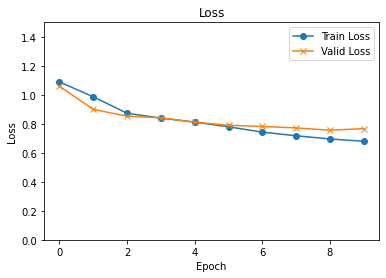

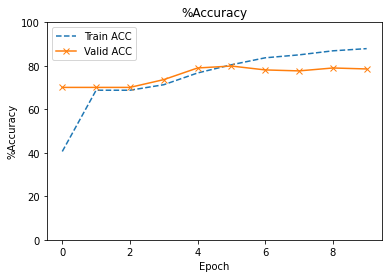

In [39]:
# Plotting metrics to see how model as learned and loss decreased
import numpy as np
import matplotlib.pyplot as plt

plt.plot(range(N_EPOCHS), trainLoss, marker='o')
plt.plot(range(N_EPOCHS), validLoss, marker = 'x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Valid Loss"])
plt.title("Loss")
plt.ylim([0,1.5])
plt.show()

plt.plot(range(N_EPOCHS), np.dot(trainAcc,100), linestyle='dashed')
plt.plot(range(N_EPOCHS), np.dot(validAcc,100), marker = 'x')
plt.xlabel("Epoch")
plt.ylabel("%Accuracy")
plt.legend(["Train ACC", "Valid ACC"])
plt.title("%Accuracy")
plt.ylim([0,100])
plt.show()

## Confusion Matrix
Using only validatin dataset

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

In [41]:
y_true = []
y_pred = []
x_tweet = []

for batch in valid_iterator:
  # retrieve text and no. of words
  tweet, tweet_lengths = batch.tweet
  
  # convert to 1d tensor
  encoder_out, embedding = encoder(tweet, tweet_lengths)

  predictions , decoder_out = decoder(encoder_out)
  _, pred = torch.max(predictions, 1) 
  y_pred = np.concatenate((y_pred, pred))

  y_true = np.concatenate((y_true, batch.label.detach().numpy() ))
  x_tweet = tweet
  
#print(tweet)
#print(len(y_true))
#print(y_true)
#print(y_pred)

r = sklearn.metrics.multilabel_confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
r

array([[[ 47,  20],
        [ 23, 115]],

       [[121,  28],
        [ 14,  42]],

       [[194,   0],
        [ 11,   0]]])

In [52]:
#sns.heatmap(r[0], cmap="YlGnBu", annot=True, yticklabels=['Pred_Negative', 'Pred_Positive'])
print( sklearn.metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84       138
         1.0       0.60      0.75      0.67        56
         2.0       0.00      0.00      0.00        11

    accuracy                           0.77       205
   macro avg       0.48      0.53      0.50       205
weighted avg       0.74      0.77      0.75       205



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Examples of wrongly classified tweets
Will it be difficult for human as well to classify the sentiment?

## Sample Output from Encoder & Decoder

## Only one o/p per sentence

In [48]:
# write a function which 
# i/p : 1d array, n(shape)
# plots the heat maps

def power_plot(m, n1, n2, token, t='title'):
  m = m.reshape(n1, n2)
  plt.figure(figsize=(8, 6), dpi=80)
  sns.heatmap(m, cmap="YlGnBu", yticklabels=token)
  plt.title(t)
  plt.show()

In [49]:
#load weights and tokenizer

en_path='./encoder_saved_weights.pt'
encoder.load_state_dict(torch.load(en_path));
encoder.eval();

de_path='./decoder_saved_weights.pt'
decoder.load_state_dict(torch.load(de_path));
decoder.eval();

tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def explainNclassify_tweet(tweet):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    # prediction = model(tensor, length_tensor)
    encoder_out, embedding = encoder(tensor, length_tensor)
    prediction, decoder_out = decoder(encoder_out) #.squeeze()

    _, pred = torch.max(prediction, 1) 
    
    print('Tokenized : ', tokenized)
    print('Index of words : ', indexed)
    print('Number of words : ', length[0])
    print('tensor', tensor.shape)
    print('tensor', tensor)
    print('**********************************************************')
    
    power_plot(embedding[0,:,:].detach().numpy(), length[0], 324, tokenized, 'Embeddings Output' )
    print(embedding.shape)

    power_plot(encoder_out[0,:,:].detach().numpy(), length[0], 144, tokenized, 'Encoder Output' )
    print(encoder_out.shape)

    power_plot(decoder_out[0,:,:].detach().numpy(), length[0], 64, tokenized, 'Decoder Output' )
    print(decoder_out.shape)

    print('*********************************************************')
    kpiMedian = []
    kpiMean = []
    kpiStd = []
    for i in range(length[0]):
      kpiMedian.append(np.median(encoder_out[0,i,:].detach().numpy()))
      kpiMean.append(np.mean(encoder_out[0,i,:].detach().numpy()))
      kpiStd.append(np.std(encoder_out[0,i,:].detach().numpy()))

    plt.figure(figsize=(5, 1), dpi=80)
    sns.heatmap(np.array(kpiMedian).reshape(1,3), cmap="YlGnBu", annot=True, xticklabels=tokenized, yticklabels='')
    plt.title('Median of Decoder LSTM Output')
    plt.show()
    plt.figure(figsize=(5, 1), dpi=80)
    sns.heatmap(np.array(kpiMean).reshape(1,3), cmap="YlGnBu", annot=True, xticklabels=tokenized, yticklabels='')
    plt.title('Mean of Decoder LSTM Output')
    plt.show()
    plt.figure(figsize=(5, 1), dpi=80)
    sns.heatmap(np.array(kpiStd).reshape(1,3), cmap="YlGnBu", annot=True, xticklabels=tokenized, yticklabels='')
    plt.title('Stdev of Decoder LSTM Output')
    plt.show()


    return categories[pred.item()]

Tokenized :  ['Not', 'best', 'experience']
Index of words :  [365, 738, 0]
Number of words :  3
tensor torch.Size([1, 3])
tensor tensor([[365, 738,   0]])
**********************************************************


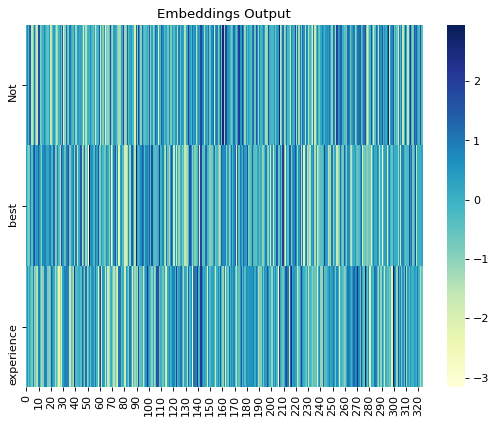

torch.Size([1, 3, 324])


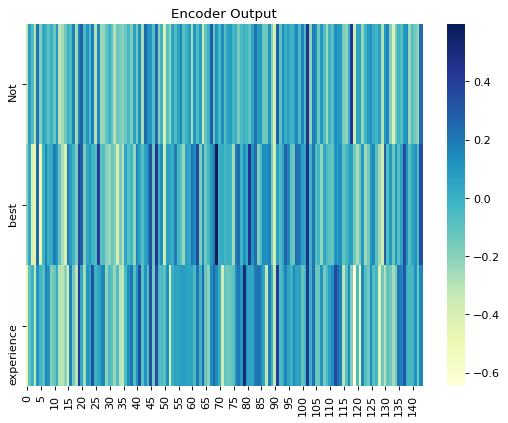

torch.Size([1, 3, 144])


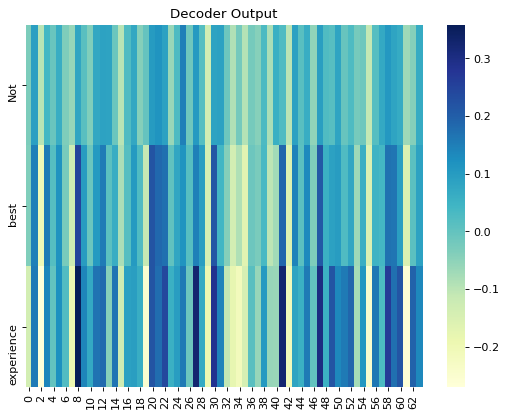

torch.Size([1, 3, 64])
*********************************************************


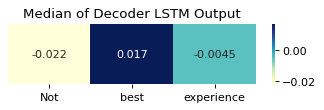

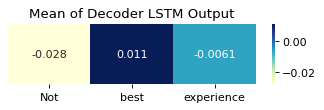

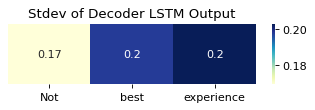

Negative


In [50]:
print(explainNclassify_tweet("Not best experience"))

Tokenized :  ['The', 'best', 'experience']
Index of words :  [61, 738, 0]
Number of words :  3
tensor torch.Size([1, 3])
tensor tensor([[ 61, 738,   0]])
**********************************************************


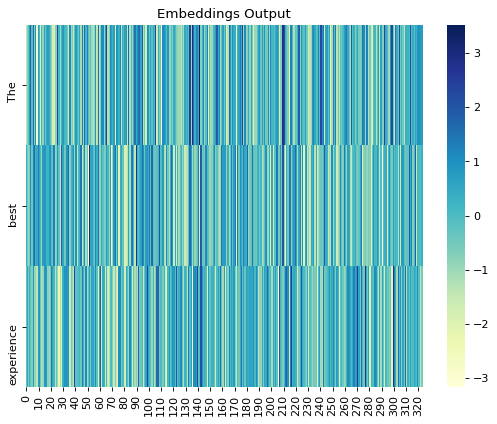

torch.Size([1, 3, 324])


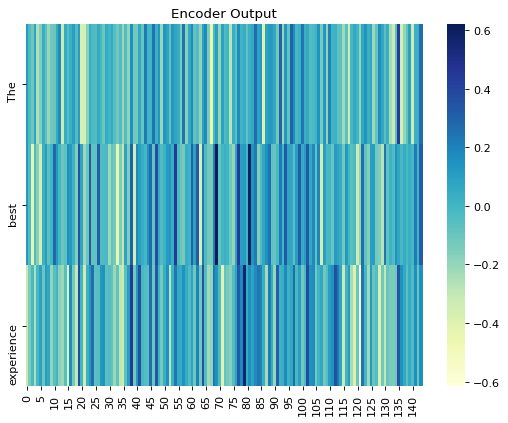

torch.Size([1, 3, 144])


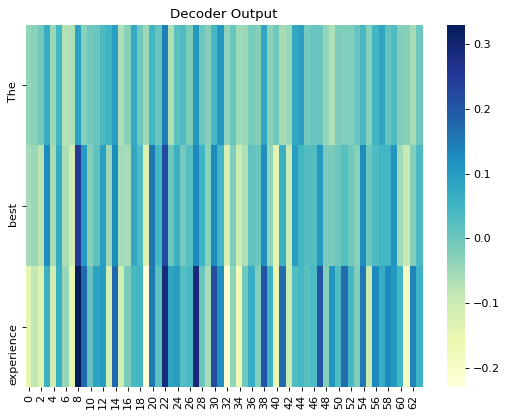

torch.Size([1, 3, 64])
*********************************************************


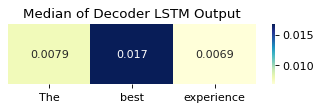

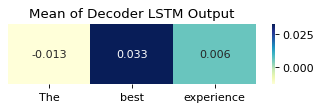

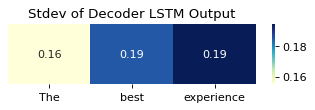

Positive


In [51]:
print(explainNclassify_tweet("The best experience"))